In [20]:
import time
import os
import io
import torch
import sys
import os 
import PIL.Image
dir_path = os.path.dirname(os.path.realpath(os.getcwd()))
sys.path.insert(0,dir_path)
from dataloader import Dataset_from_pkl
from model_cvae import CvaeFuture
from torch.utils.tensorboard import SummaryWriter
import torch.distributions as D
from train_with_future import get_ade_fde_vel
from visualize import visualize_single
from torchvision.transforms import ToTensor



In [21]:
training_set = Dataset_from_pkl("/home/robot/repos/trajectory-prediction/processed/", data_files=["eth_train.pkl"])
training_generator = torch.utils.data.DataLoader(training_set, batch_size=1, shuffle=True)

test_set = Dataset_from_pkl("/home/robot/repos/trajectory-prediction/processed/", data_files=["eth_test.pkl"])
test_generator = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(device)
model = CvaeFuture(lstm_hidden_dim=64, num_layers=1, bidir=True, dropout_p=0.0, num_modes=30).to(device)
model.load_state_dict(torch.load("/home/robot/repos/trajectory-prediction/tb/CvaeFuture0.0005_hd_64_ed_0_nl_1@17.08.2020-19:03:59/CvaeFuture0.0005_hd_64_ed_0_nl_1@17.08.2020-19:03:59+best.pth"))



loading eth_train.pkl
loading eth_test.pkl
cuda


/home/robot/miniconda3/envs/pytorch_env/lib/python3.8/site-packages/torch/nn/modules/rnn.py:47: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<All keys matched successfully>

In [27]:
# print(model.parameters())
import numpy as np
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

314428

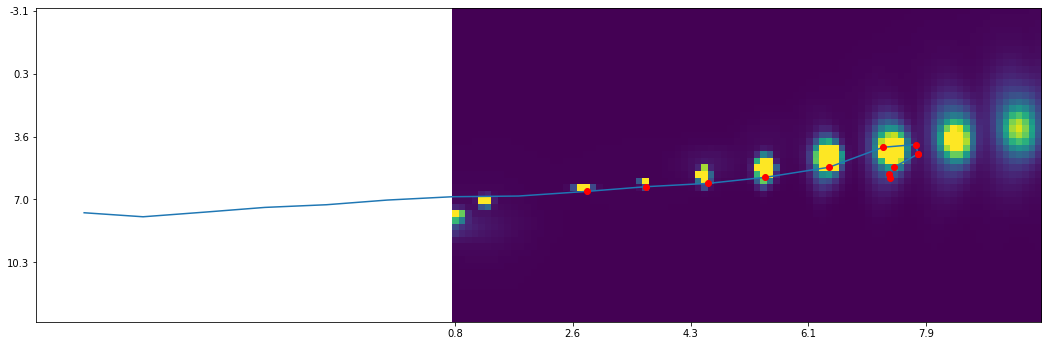

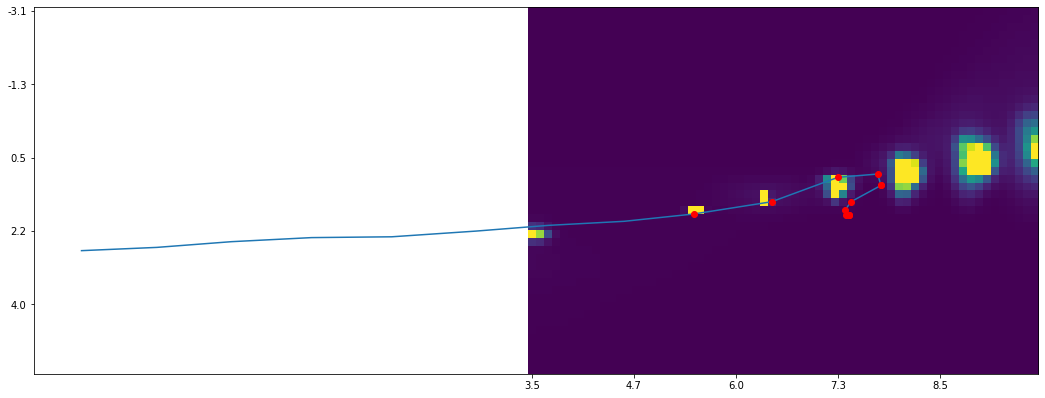

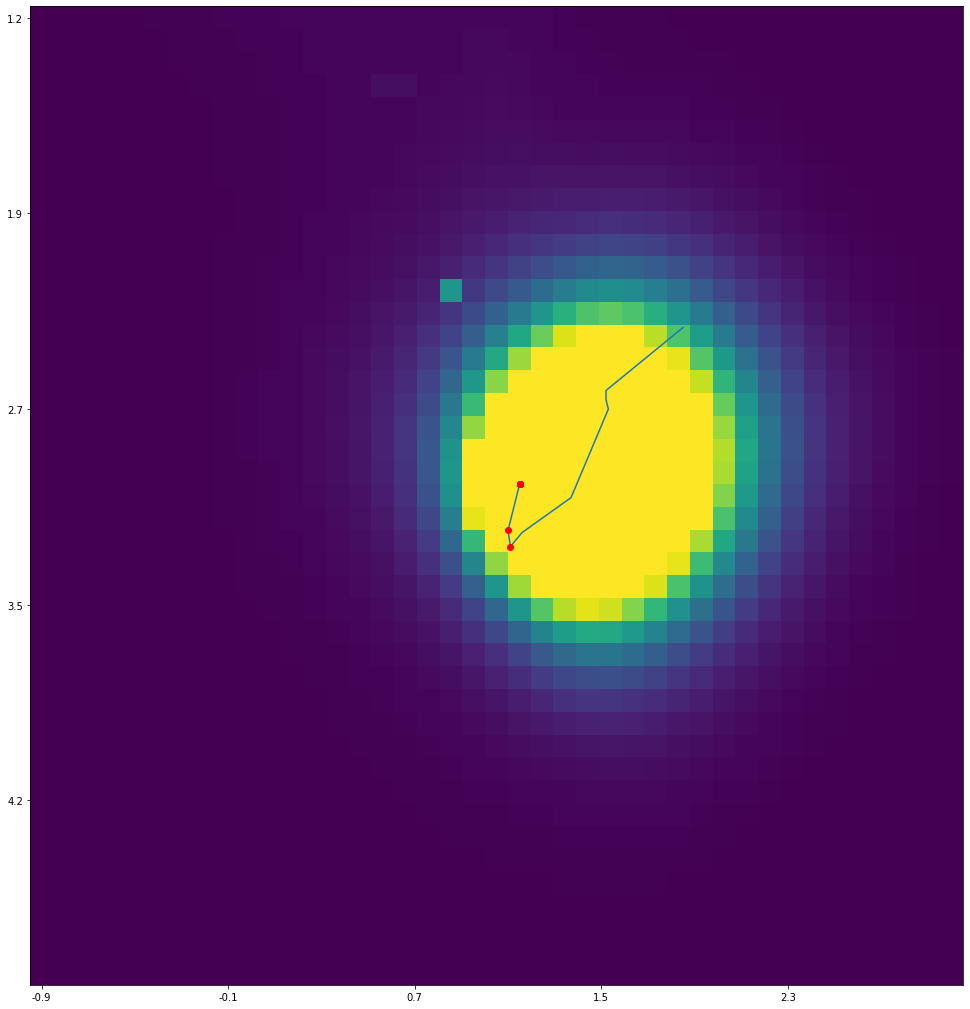

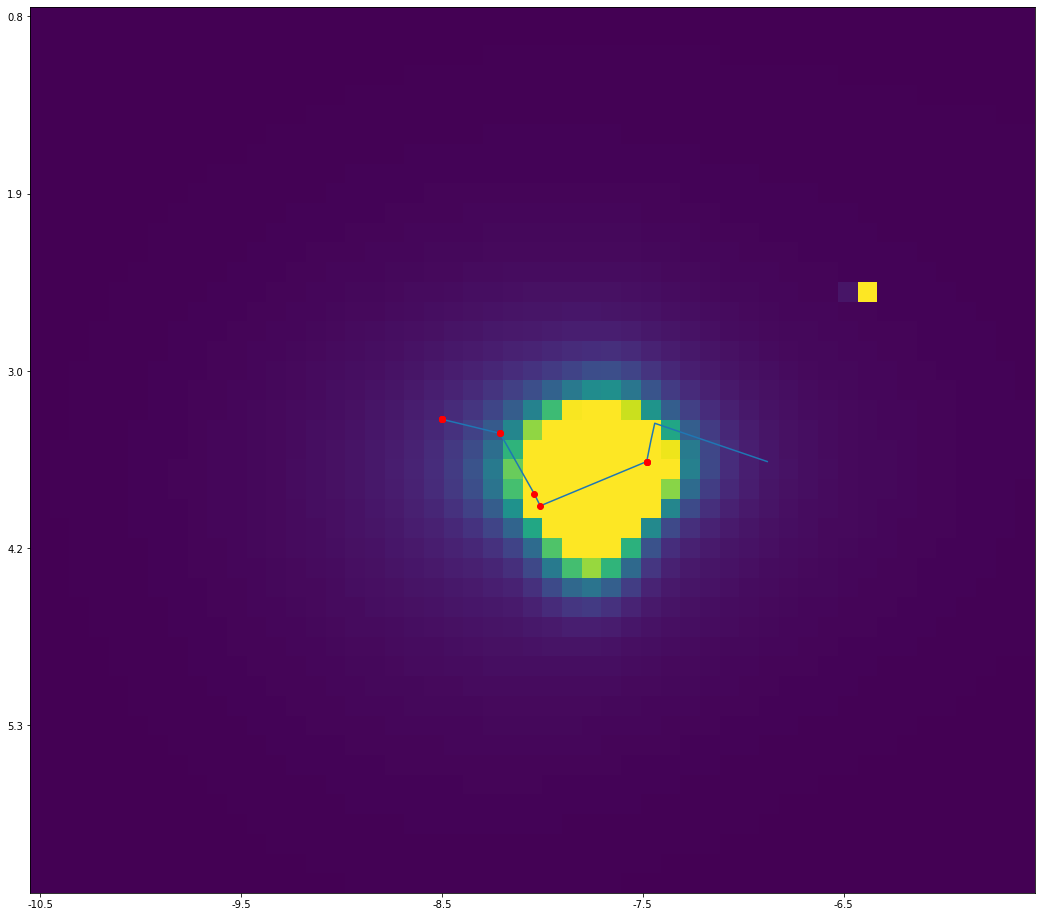

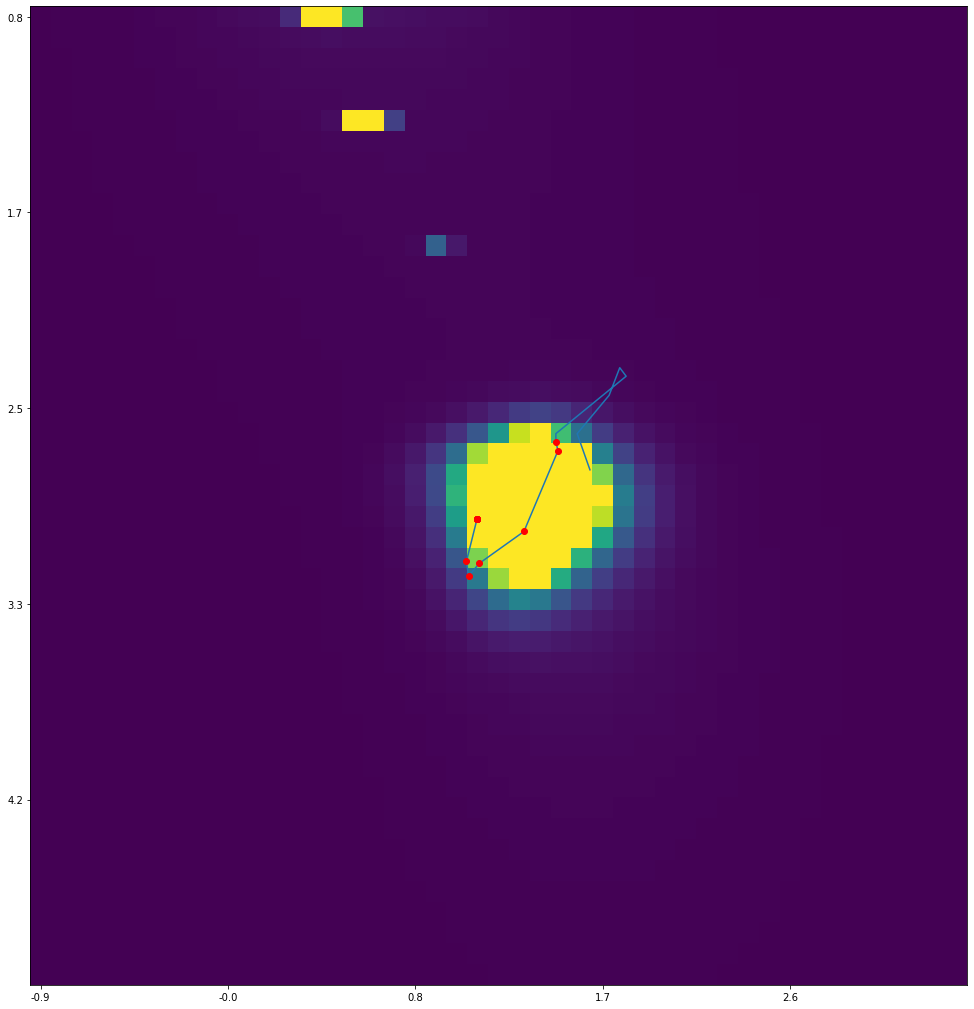

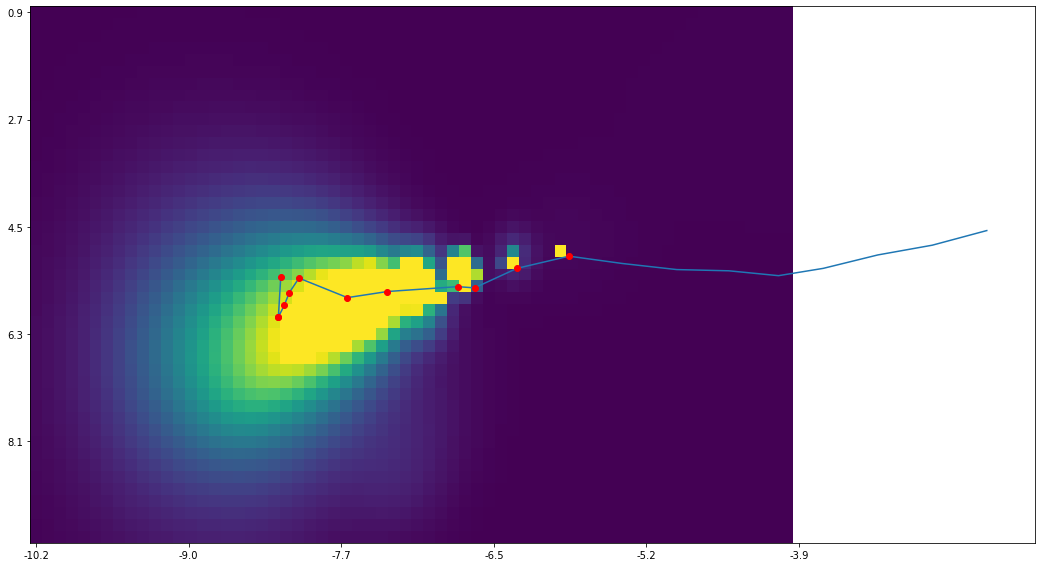

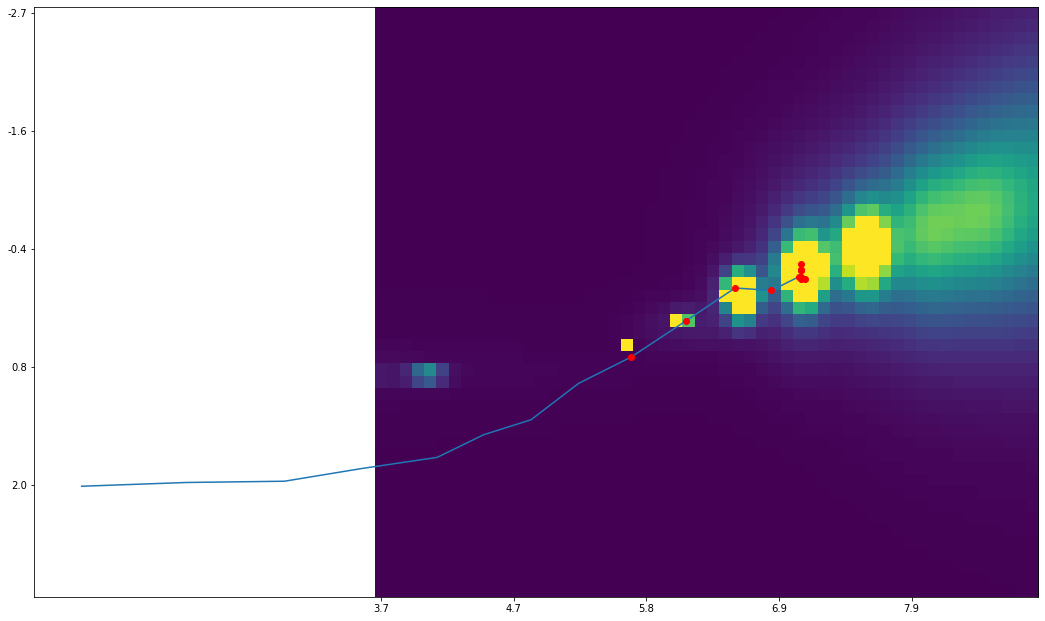

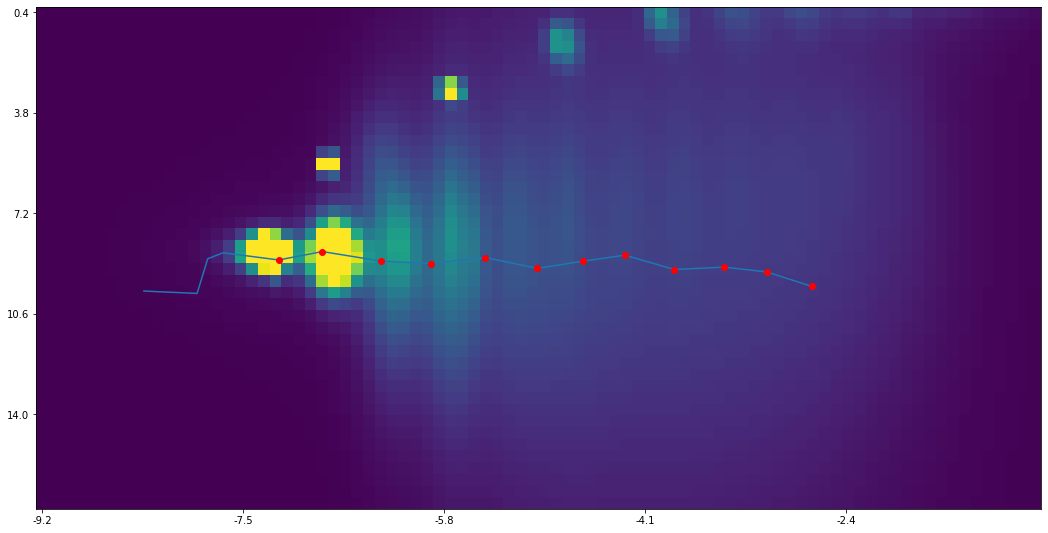

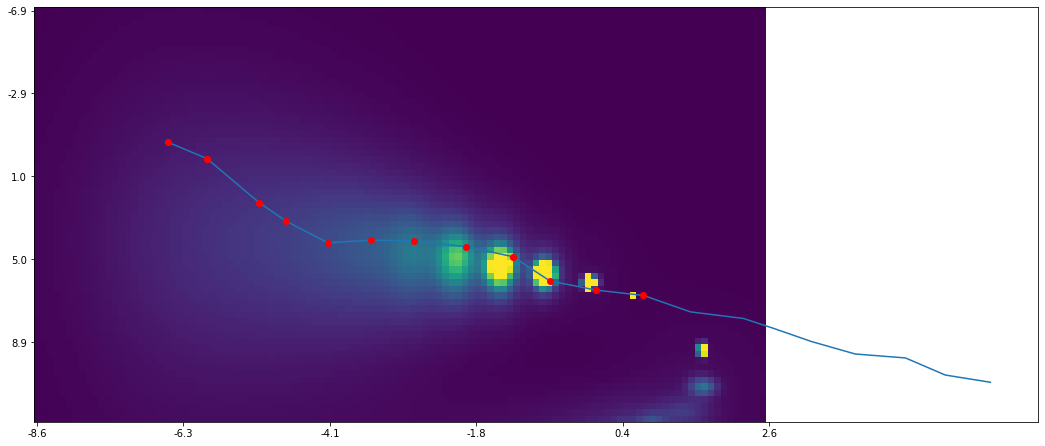

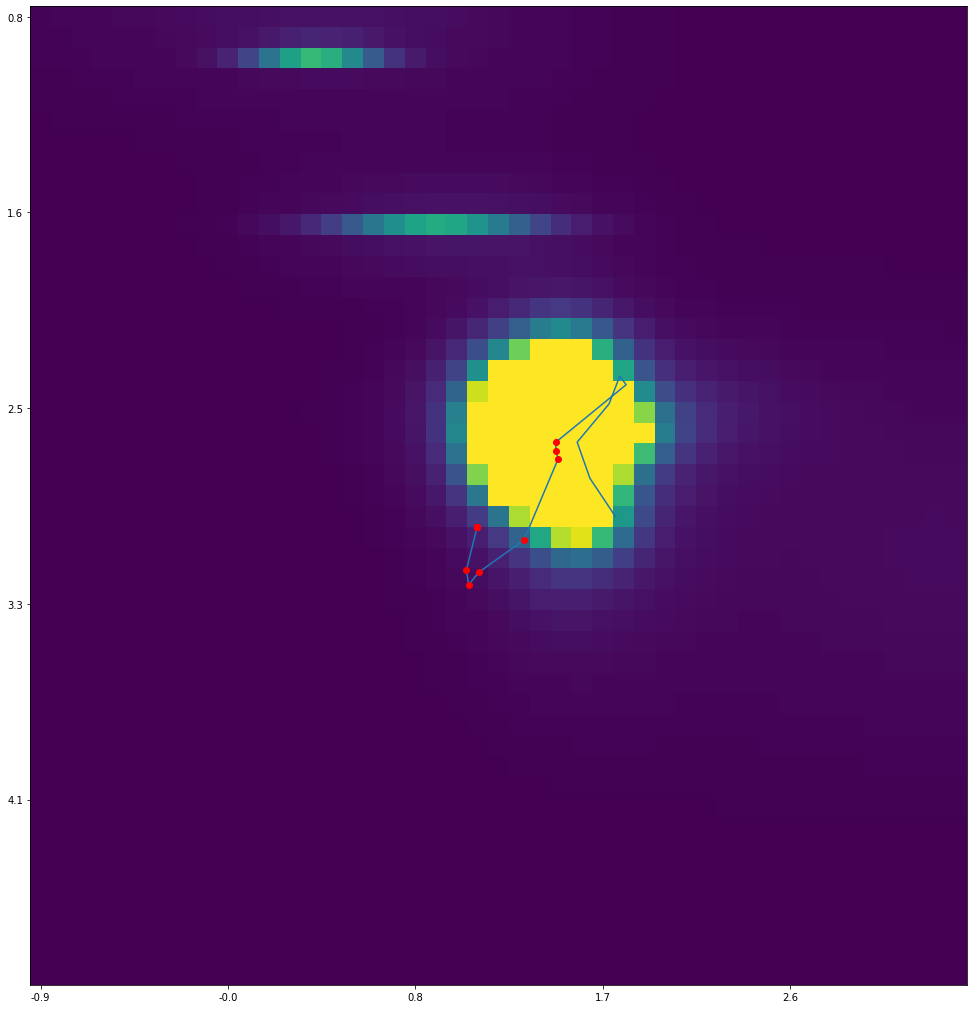

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
buf = []
for i in range(2):
    visualize_single(model, test_generator)
    buff = io.BytesIO()
    plt.savefig(buff, format='jpeg')
    buff.seek(0)
    image = PIL.Image.open(buff)
    buf.append(ToTensor()(image))

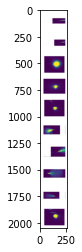

In [30]:
from torchvision import transforms
import torch.nn.functional as F
from torchvision.transforms import Resize
smaller = []
# for img in buf:
    
#     smaller.append(F.interpolate(img, size=(256,256)))
trans = transforms.ToPILImage(mode='RGB')
plt.imshow(trans(torch.cat(buf,dim=1)).resize((256,2048)))

In [35]:
from dataloader_parallel import Dataset_from_pkl

In [56]:
dataset = Dataset_from_pkl("/home/robot/repos/trajectory-prediction/processed_with_forces/", data_files=["eth_test.pkl"])

loading eth_test.pkl


In [57]:
for i in tqdm(range(dataset.data_length)):
    dataset.__getitem__(i)

100%|██████████| 5472/5472 [00:14<00:00, 383.89it/s]


In [58]:
upper_bounds = list(dataset.dataset_indeces.keys())
upper_bounds.append(0)
upper_bounds.sort()
upper_bounds
for i, (dataset_name, index) in enumerate(dataset.dataset_indeces.values()):
    print (i, dataset_name, index)
    print(upper_bounds[i])
    print(upper_bounds[i+1])
    torch.save(dataset.processed_history[upper_bounds[i]:upper_bounds[i+1]], "../preprocessed/"
                       + dataset_name[:dataset_name.index(".")]+str(index)+".pt")
    torch.save(dataset.processed_neighbors[upper_bounds[i]:upper_bounds[i + 1]], "../preprocessed/"
                       + dataset_name[:dataset_name.index(".")] + str(index) + "neighbors.pt")


0 eth_test.pkl 0
0
5472


In [59]:
a = []
for i, (dataset_name, index) in enumerate(dataset.dataset_indeces.values()):
    a.append(torch.load("../preprocessed/"
                       + dataset_name[:dataset_name.index(".")]+str(index)+".pt"))

a = torch.cat(a)
print (a.shape)

torch.Size([5472, 20, 14])


In [36]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.1)


In [4]:
import torch
import torch.nn as nn

inp = torch.rand(4,8,2)
nh = nn.LSTM(input_size=2,hidden_size=10,batch_first=True)

In [16]:

f_out = nh(inp)[0]

In [11]:
for i in range(inp.shape[1]):
    if i == 0:
        out, state = nh(inp[:,i:i+1,:])
    else:
        out, state = nh(inp[:,i:i+1,:], state)

In [86]:
t = torch.rand(123,106)
print(torch.mean(t[:,0]))
bn = nn.BatchNorm1d(106)
t_n = bn(t)
print(torch.mean(t_n[:,0]))


tensor(0.4928)
tensor(-5.9120e-08, grad_fn=<MeanBackward0>)


In [131]:
t = torch.rand(16,8,126)
print(torch.mean(t[:,:,0]))
print(torch.mean(t[0]))
bn = nn.LayerNorm([8,126])
t_n = bn(t)
print(torch.mean(t_n[0,0,:]))
print(torch.mean(t_n[0]))

tensor(0.4900)
tensor(0.5132)
tensor(-0.0649, grad_fn=<MeanBackward0>)
tensor(-1.8224e-07, grad_fn=<MeanBackward0>)
